In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np

from numpy.linalg import norm
from math import sqrt

**Huge diffusion file in a google disk**

In [2]:
def make_df_get_Dt(path, N):
    df = pd.read_csv(path, skiprows=[0,1, 2])

    with open(path) as f:
        f.readline()
        line = f.readline()

    Dt = float(line.split(':')[-1][:-1])    # шаг по времени для соседних строчек в диффузии

    return df, Dt

In [3]:
path1 = './graphs/diff_N100_t50_interval10dt.csv'
path2 = './graphs/diff_N_100_dt0_00025.csv'
N = 100

df1, Dt1 = make_df_get_Dt(path=path1, N=N)
df2, Dt2 = make_df_get_Dt(path=path2, N=N)

In [4]:
df1.shape

(6000, 400)

In [11]:
df2.shape

(45000, 400)

**Условие чтобы не было list index out of range для пандаса: предыдущее + step <= количество строк, пример когда ломается: **


In [6]:
def calculate_all_means(number_of_steps, df, Dt):
    '''
    Возвращает массив из усредненного по всем перемещениям для каждой частицы и затем по всем частиц из перемещений для разных времен перемещения
    и массив отрезков времени для которых как раз получено значение перемещения.
    df: pd.Dataframe
    Dt: расстояние по времени между двумя соседними строчками в датафрейме
    '''

    steps = [step for step in range(0, number_of_steps + 1, 200)]    # это степы для которых я смотрю квадрат перемещения
    print(steps)
    
    all_means = []
    for step in steps:
        part_dict = {}
        for i in range(N):
            part_dict[i] = np.array([])
        
        for row_numb in steps:
            for p_numb in range(N):
                row = df.iloc[row_numb]
                x = row[str(p_numb) + 'x']
                y = row[str(p_numb) + 'y']
                z = row[str(p_numb) + 'z']
                pos = np.array([x, y, z])

                row_next = df.iloc[row_numb + step]     # берем для той же частицы с шагом step ряд
                x_next = row_next[str(p_numb) + 'x']
                y_next = row_next[str(p_numb) + 'y']
                z_next = row_next[str(p_numb) + 'z']
                pos_next = np.array([x_next, y_next, z_next])
                
                s_square = norm(pos_next - pos) ** 2
                # s_square = (x_next - x) ** 2 + (y_next - y) ** 2 + (z_next - z) ** 2
                # print(s_square)
                part_dict[p_numb] = np.append(part_dict[p_numb], s_square)

        mean_dict = {}
        for i in range(N):
            mean_dict[i] = part_dict[i].mean()

        total_mean_for_step = np.array(list(mean_dict.values())).mean()

        all_means.append(total_mean_for_step)

    return all_means, Dt * np.array(steps)
    

In [7]:
all_means1, dt_of_steps1 = calculate_all_means(1500, df=df1, Dt=Dt1)

[0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500]


In [12]:
all_means2, dt_of_steps2 = calculate_all_means(20000, df=df2, Dt=Dt2)

[0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100, 2150, 2200, 2250, 2300, 2350, 2400, 2450, 2500, 2550, 2600, 2650, 2700, 2750, 2800, 2850, 2900, 2950, 3000, 3050, 3100, 3150, 3200, 3250, 3300, 3350, 3400, 3450, 3500, 3550, 3600, 3650, 3700, 3750, 3800, 3850, 3900, 3950, 4000, 4050, 4100, 4150, 4200, 4250, 4300, 4350, 4400, 4450, 4500, 4550, 4600, 4650, 4700, 4750, 4800, 4850, 4900, 4950, 5000, 5050, 5100, 5150, 5200, 5250, 5300, 5350, 5400, 5450, 5500, 5550, 5600, 5650, 5700, 5750, 5800, 5850, 5900, 5950, 6000, 6050, 6100, 6150, 6200, 6250, 6300, 6350, 6400, 6450, 6500, 6550, 6600, 6650, 6700, 6750, 6800, 6850, 6900, 6950, 7000, 7050, 7100, 7150, 7200, 7250, 7300, 7350, 7400, 7450, 7500, 7550, 7600, 7650, 7700, 7750, 7800, 7850, 7900, 7950, 8000, 8050, 8100, 8150, 8200, 8250, 8300, 8350, 8400, 8450, 85

KeyboardInterrupt: 

In [ ]:
def calculate_k(x, y, through_zero=False):
    '''Вычисление коэффициентов для аппроксимации зависимостью y = kx + b'''
    n = len(x)
    m_x = x.mean()
    m_y = y.mean()
    m_xx = (x * x). mean()
    m_yy = (y * y).mean()
    m_xy = (x * y).mean()
    m_x_m_x = x.mean() * x.mean()
    m_y_m_y = y.mean() * y.mean()

    k = 0
    s_k = 0
    b = 0
    s_b = 0

    if through_zero:
        k = m_xy / m_xx
        s_k = (1 / sqrt(n)) * sqrt((m_yy / m_xx) - k ** 2)
        return [k, s_k]

    else:
        k = (m_xy - m_x * m_y) / (m_xx - m_x_m_x)
        b = m_y - k * m_x

        s_k = (1 / sqrt(n)) * sqrt((m_yy - m_y_m_y) / (m_xx - m_x_m_x) - k ** 2)
        s_b = s_k * sqrt(m_xx - m_x_m_x)
        return [k, s_k, b, s_b]

In [ ]:
k1, _, b1, _ = calculate_k(np.array(dt_of_steps1), np.array(all_means1))
k2, _, b2, _ = calculate_k(np.array(dt_of_steps2), np.array(all_means2))

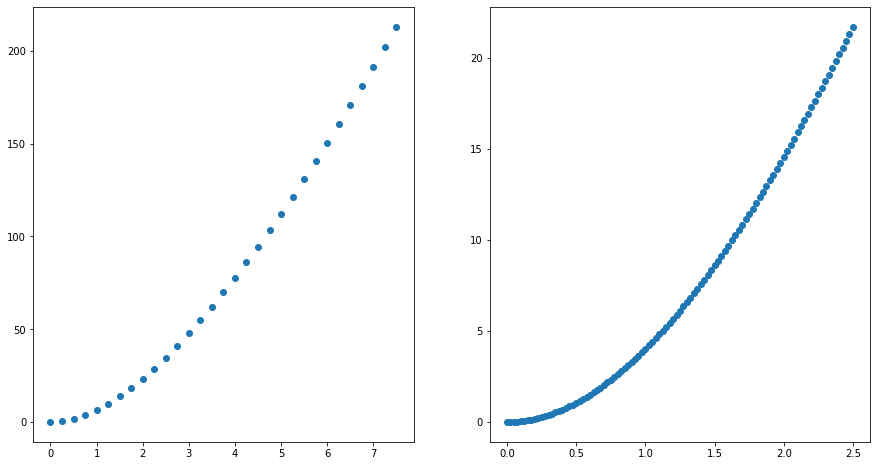

In [9]:
sp = None
plt.figure(figsize=(15, 8))

sp = plt.subplot(1, 2, 1)
plt.scatter(dt_of_steps1, all_means1)
sp = plt.subplot(1, 2, 2)
plt.scatter(dt_of_steps2, all_means2)

plt.show()

Время когда парабола переходит в прямую - это время свободного пробега. Самый простой вариант это понять - в логарифмических координатах. Когда у нас парабола - это s^2 = t^2, то есть это просто свободное движение частицы. Короче вот такая вот парабола это правильно

Сейчас задача - построить достаточно широко по координате delta_t перемещения, чтобы было видно нормально и прямую и параболу